# Credit Card Fraud Detection (Modeling, Notebook 2)
Author: Brenda De Leon

In this notebook we will compare different methods to addressing the dataset's high imbalance. We will see which method works best for the data we have been provided, with an overwhelming majority class. With the minority class only representing 0.0017 of the cases, we will try: oversampling, undersampling, and SMOTE, as well as compare between scalers (with a grid search and column transformer pipelines). We will create models using: Logistic Regression, SVMs, Decision trees, and KNN. Additionally, we will use metrics calculated using the confusion matrix and ROC curves to inform us of the models performance.

#### Libraries

In [ ]:
# importing libraries
# importing libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
plt.style.use('ggplot')

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Ridge, LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error, plot_confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, plot_roc_curve, confusion_matrix, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve, auc, PrecisionRecallDisplay, average_precision_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
import warnings
warnings.filterwarnings("ignore")

In [250]:
# importing data
# importing dataset
df = pd.read_csv('data/creditcard.csv')
df.head().append(df.tail())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.62,0
1,0.0,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.69,0
2,1.0,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.66,0
3,1.0,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.50,0
4,2.0,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.99,0
284802,172786.0,-11.881,10.072,-9.835,-2.067,-5.364,-2.607,-4.918,7.305,1.914,...,0.213,0.112,1.014,-0.509,1.437,0.250,0.944,0.824,0.77,0
284803,172787.0,-0.733,-0.055,2.035,-0.739,0.868,1.058,0.024,0.295,0.585,...,0.214,0.924,0.012,-1.016,-0.607,-0.395,0.068,-0.054,24.79,0
284804,172788.0,1.920,-0.301,-3.250,-0.558,2.631,3.031,-0.297,0.708,0.432,...,0.232,0.578,-0.038,0.640,0.266,-0.087,0.004,-0.027,67.88,0
284805,172788.0,-0.240,0.530,0.703,0.690,-0.378,0.624,-0.686,0.679,0.392,...,0.265,0.800,-0.163,0.123,-0.569,0.547,0.109,0.105,10.00,0
284806,172792.0,-0.533,-0.190,0.703,-0.506,-0.013,-0.650,1.577,-0.415,0.486,...,0.261,0.643,0.377,0.009,-0.474,-0.818,-0.002,0.014,217.00,0


## Evaluation Function

In [307]:
# defining an evaluation classification function for automation and evaluating subsequent models
def evaluate_classification(model, X_train, X_val, y_train, y_val, classes=None, 
                            normalize='true', cmap='Reds', label=''):
    
    """Input a model, training data and validation data to return sklearn metrics
        - Classification Report for training and validation 
        - PR AUC Score for training and validation 
        - Confusion Matrix for training and validation 
        - ROC Curve for training and validation
        - PR Curve for training and validation
        
        Args:
        model: instantiated classifier (ex: LogisticRegression = log_reg)
        X_train: train_test_split & preprocessed
        X_val: train_test_split 
        y_train: train_test_split & preprocessed
        y_val: train_test_split 
        label: optional label for type of classifier 
    """
    # retrieve predictions for train and validation data 
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # retrieve probabilites for train and validation data 
    y_hat_train = model.predict_proba(X_train)
    y_hat_val = model.predict_proba(X_val)
    
    # retrieve probabilities for the positive class
    pos_probs_train = y_hat_train[:, 1]
    pos_probs_val = y_hat_val[:, 1]
    
    # print training classification report 
    header = label + " CLASSIFICATION REPORT TRAINING "
    dashes = "---" * 20
    print(dashes, header, dashes, sep='\n')
    print(classification_report(y_train, y_pred_train, target_names=classes))
    
    # display training figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
    
    # plot confusion matrix 
    plot_confusion_matrix(model, X_train, y_train, labels=classes,
                         cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix Training')
    
    # plot ROC curve 
    plot_roc_curve(model, X_train, y_train, ax=axes[1], name=label)
    roc = axes[1]
    roc.plot([0,1], [0,1], ls=':', label='No Skill')
    roc.grid()
    roc.set_title('Receiving Operator Characteristic Training')
    
    # plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Training')
    fig.tight_layout()
    plt.show()

    # print validation classification report 
    header_ = label + " CLASSIFICATION REPORT VALIDATION "
    print(dashes, header_, dashes, sep='\n')
    print(classification_report(y_val, y_pred_val, target_names=classes))
    
    # display validation figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    
    # plot confusion matrix 
    plot_confusion_matrix(model, X_val, y_val, labels=classes, 
                          cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix Validation')
    
    # plot ROC curve 
    plot_roc_curve(model, X_val, y_val, ax=axes[1], name=label)
    axes[1].plot([0,1], [0,1], ls=':', label='No Skill')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic Validation')

    # plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_val, y_val, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Validation')
    plt.legend()
    fig.tight_layout()
    plt.show()

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Data Split

In [253]:
# defining x and y for data split
X = df.drop('Class', axis=1)
y = df['Class']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# train test split to have a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Pipeline Building

To avoid data leakage we will build a model using a pipeline and columntransformers. Using pipeline and columntransformer helps prevent data leakage by creating a clear separation between the preprocessing and modeling steps. We are able to apply different preprocessing steps to specific features in the data with columntransformers. 

While the 28 anonymized columns have gone through some standardization before having been transformed through PCA, columns: 'Time' and 'Amount' need to be standardized so that each variable contributes more equally to the analysis. 

'Time' and 'Amount' represent very different information and we want to take into account the properties of each column. We will compare scaling methods to decide which is more appropriate for each column. Our columntransformer will contain a subpipeline for each different preprocessing step. We will start with a subpipeline for 'Amount'

### Sub-pipeline for 'Amount'

In [254]:
# distribution summary of the amount feature  
pd.set_option('precision', 3)
print('Summary of: AMOUNT' + '\n----------------------------')
print(df['Amount'].describe())

Summary of: AMOUNT
----------------------------
count    284807.000
mean         88.350
std         250.120
min           0.000
25%           5.600
50%          22.000
75%          77.165
max       25691.160
Name: Amount, dtype: float64


The 'Amount' variables vary widely and can confuse our models. We definetely want to address the outliers and large differences. 

We will consider different scaling methods for our model to determine the best one for our dataset. Each method has its own benefits and drawbacks:

- <b>Log Transformation:</b> This method can help with data that has a skewed distribution, such as many zeros or values close to zero. The 'Amount' column is heavily skewed, however we do not have many zero amount transactions and the average amount value is not close to zero it is 88. 


- <b>Standard Scaler:</b> This method scales data to have a mean of zero and a standard deviation of one. It is a popular method for normalizing data, but can be sensitive to outliers. The 'Amount' column has outliers with the average value being 88 and the largest value being 25691.160. While this is a popular method, we will consider other scaling methods that deal better with outliers and skewed data.


- <b>MinMax Scaler:</b> This method scales data to be between 0 and 1. This can be useful for data that has a skewed distribution, but can also be sensitive to outliers. While this method can possibly address the skewed data, we will also consider other scaling methods that deal better with outliers as the 'Amount' column's max value is over 250 times larger than it's average value.


- <b>Robust Scaler:</b> This method is similar to standard scaling, but is less sensitive to outliers. It is possible that the outliers in the 'Amount' column can be useful characteristics to indicating a fraud transaction. It is important for the scaler to be sensitive to outliers. This method could prevent the extreme values from being given too much weight in the model. 

We will use each method to scale 'Amount' and save the results of each in new columns to compare.

In [255]:
# scale amount by log transformation
log_scaling_pipe = Pipeline([('log_scaling', FunctionTransformer(np.log1p, validate=False)),])
# data is converted into 2D array. scaler is fitted to data and scales it. 
df['amount_log'] = log_scaling_pipe.fit_transform(df['Amount'].values.reshape(-1,1))

# scale amount by standardization
ss = StandardScaler()
# data is converted into 2D array. scaler is fitted to data and scales it. 
df['amount_scaled'] = ss.fit_transform(df['Amount'].values.reshape(-1,1))

# scale amount by normalization
norm = MinMaxScaler()
# data is converted into 2D array. scaler is fitted to data and scales it. 
df['amount_minmax'] = norm.fit_transform(df['Amount'].values.reshape(-1,1))

# robust scaling amount
rs = RobustScaler()
# data is converted into 2D array. scaler is fitted to data and scales it. 
df['amount_robust'] = rs.fit_transform(df['Amount'].values.reshape(-1,1))

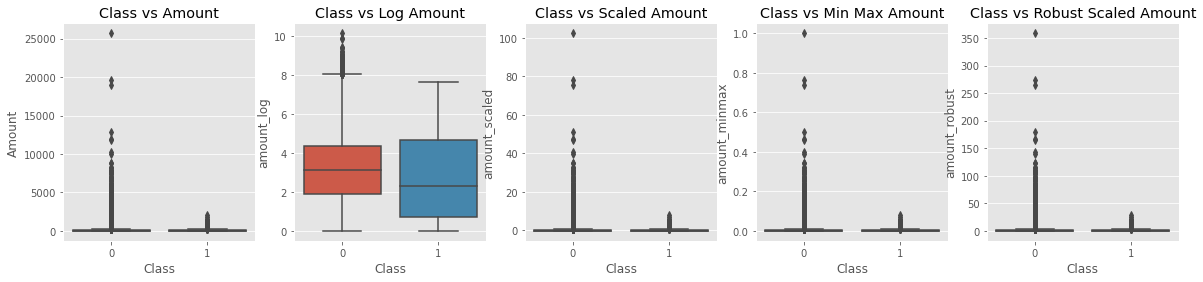

In [256]:
fig,axs = plt.subplots(nrows = 1 , ncols = 5 , figsize = (20,4))

sns.boxplot(x ="Class",y="Amount",data=df, ax = axs[0])
axs[0].set_title("Class vs Amount")

sns.boxplot(x ="Class",y="amount_log",data=df, ax = axs[1])
axs[1].set_title("Class vs Log Amount")

sns.boxplot(x ="Class",y="amount_scaled",data=df, ax = axs[2])
axs[2].set_title("Class vs Scaled Amount")

sns.boxplot(x ="Class",y="amount_minmax",data=df, ax = axs[3])
axs[3].set_title("Class vs Min Max Amount")

sns.boxplot(x ="Class",y="amount_robust",data=df, ax = axs[4])
axs[4].set_title("Class vs Robust Scaled Amount")

plt.show()

In [257]:
# inspecting describe summaries of the different scaler results using for loop
pd.set_option('precision', 3)
columns=['amount_log', 'amount_scaled', 'amount_minmax', 'amount_robust']
for i in columns:
         print(i)
         print('\n')
         print(df[i].describe())
         print('_________________________________________________________________')

amount_log


count    284807.000
mean          3.152
std           1.657
min           0.000
25%           1.887
50%           3.135
75%           4.359
max          10.154
Name: amount_log, dtype: float64
_________________________________________________________________
amount_scaled


count    2.848e+05
mean     2.914e-17
std      1.000e+00
min     -3.532e-01
25%     -3.308e-01
50%     -2.653e-01
75%     -4.472e-02
max      1.024e+02
Name: amount_scaled, dtype: float64
_________________________________________________________________
amount_minmax


count    2.848e+05
mean     3.439e-03
std      9.736e-03
min      0.000e+00
25%      2.180e-04
50%      8.563e-04
75%      3.004e-03
max      1.000e+00
Name: amount_minmax, dtype: float64
_________________________________________________________________
amount_robust


count    284807.000
mean          0.927
std           3.495
min          -0.307
25%          -0.229
50%           0.000
75%           0.771
max         358.683
Name: amount

<b>Note:</b> The log scaling provides us with the least difference amongst the labels. It is also the least skewed distribution. The other scaled amounts are still showing large differences. They all seem to have a mean close to zero, with RobustScaler being the closest to zero. They all have a standard deviation close to one, with StandardScaler being the closest to one. This is important because some machine learning algorithms like Logistic Regression assume that the features are normally distributed with a mean of zero and a standard deviation of one.

Because outliers in our dataset may be it may be indicative of fraud, we want a scaling method that can handle outliers well. A RobustScaler can be a good choice as it can better handle outliers. The outliers will impact our distribution, this can affect the balance of our decision tree algorithms and cause overfitting. 

Robust scaling is less sensitive to outliers compared to the other methods, which is an important characteristic for the 'Amount' column. By using robust scaling, you can ensure that these values are not given too much weight in your machine learning model, which can help improve the performance of your model.

We will move forward with a sub-pipeline with RobustScaler as the scaler for 'Amount'. 

In [258]:
# create a sub-pipeline for the columntransformer scaling the 'amount' column
amount_scaler = Pipeline([  # default parameters   
    ('scaler', RobustScaler(quantile_range=(25, 75)))
])

### Sub-pipeline for 'Time'

In [259]:
# distribution summary of the time feature  
pd.set_option('precision', 3)
print('Summary of: Time' + '\n----------------------------')
print(df['Time'].describe())

Summary of: Time
----------------------------
count    284807.000
mean      94813.860
std       47488.146
min           0.000
25%       54201.500
50%       84692.000
75%      139320.500
max      172792.000
Name: Time, dtype: float64


The 'Time' variables vary widely as they represent the elapsing number of seconds since the first transaction over the period of two days. The transaction time could be an important feature to detecting fraud. We do not want to loose this data, however the values are very large and loose their interpretability in seconds. We might be able to improve the performance of the model by transforming the second variables in the 'Time' column to hour variables. Hour variables could make it easier for the model to identify and capture relevant trends.

We will create a function that will convert the time values to represent hour of the day instead of second of the day. We will later include this function as part of our subpipeline for 'Time'.

In [260]:
# first define a function to convert the 'time' column into hour variables
def convert_to_hours(X):
    return np.divide(X, 3600).astype(int)

In [261]:
# applying function to time
df['Hour'] = df['Time'].apply(lambda x:convert_to_hours(x))

After applying the convert to hours function, the range of the 'time' column is between 0 and 48 hours. We do not expect any outliers as they should all fall within the two day period. 

We want a scaler that is able to address the larger differences between some of the earlier transactions to the time stamp of the later transactions. 
We want a scaler that is able to address the larger differences between some of the earlier transactions to the time stamp of the later transactions and weight more quually despite the larger numerical value

Again, we will consider popular scaling methods and determine the best one for the 'Time' feature. Each method has its own benefits and drawbacks:

- <b>Log Transformation:</b> This method can help with data that has a skewed distribution, such as many zeros or values close to zero. The 'Time' column is not skewed, and we do not have many zero time transactions and the average amount value is not close to zero it is 25. A log transformation can also result in negative values which would not make sense as a transaction cannot take place at a negative hour. Log transformation could also alter the values so that they no longer represent a range of two days.

- <b>Standard Scaler:</b> This method scales data to have a mean of zero and a standard deviation of one. It is a popular method for normalizing data, but has the possibility of also altering our data to no longer represent a range of two days. While this is a popular method, we will also consider other scaling methods to try to preserve the innate range of our data. The 'Time' column has no outliers with the average value being 25 and the largest value being 47, which makes sense since the data spans two days. 


- <b>MinMax Scaler:</b> This method scales data to be between 0 and 1. This can be useful for data that has a skewed distribution, but can also be sensitive to outliers. We do not have outliers to consider or skewed data. Because minmaxscaler scales the data within a specified range (0,1), preserving the original lower and upper bounds of the data. The transaction time could be an important feature to detecting fraud


- <b>Robust Scaler:</b> This method is similar to standard scaling, but is less sensitive to outliers. In this case, it is not important for the scaler to be sensitive to outliers. 


We will use each method to scale 'Time' and save the results of each in new columns to compare.

In [262]:
# scale time by log transformation
log_scaling_pipe = Pipeline([('log_scaling', FunctionTransformer(np.log1p, validate=False)),])
# data is converted into 2D array. scaler is fitted to data and scales it. 
df['hour_log'] = log_scaling_pipe.fit_transform(df['Hour'].values.reshape(-1,1))

# scale time by standardization
ss = StandardScaler()
# data is converted into 2D array. scaler is fitted to data and scales it. 
df['hour_scaled'] = ss.fit_transform(df['Hour'].values.reshape(-1,1))

# scale time by normalization
norm = MinMaxScaler()
# data is converted into 2D array. scaler is fitted to data and scales it. 
df['hour_minmax'] = norm.fit_transform(df['Hour'].values.reshape(-1,1))

# robust scaling time
rs = RobustScaler()
# data is converted into 2D array. scaler is fitted to data and scales it. 
df['hour_robust'] = rs.fit_transform(df['Hour'].values.reshape(-1,1))

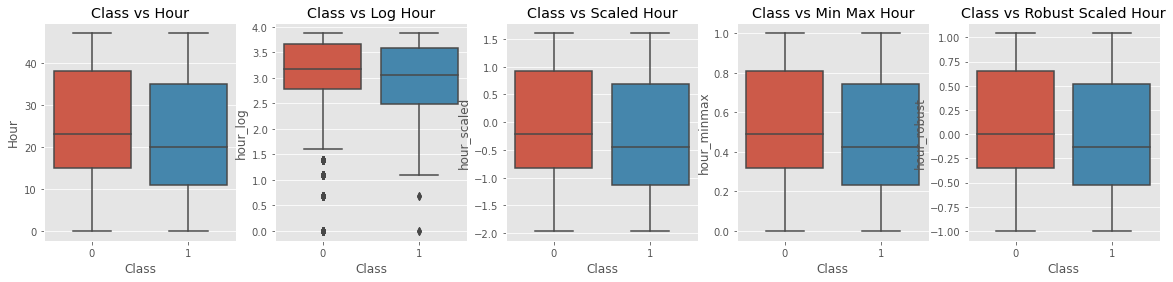

In [263]:
fig,axs = plt.subplots(nrows = 1 , ncols = 5 , figsize = (20,4))

sns.boxplot(x ="Class",y="Hour",data=df, ax = axs[0])
axs[0].set_title("Class vs Hour")

sns.boxplot(x ="Class",y="hour_log",data=df, ax = axs[1])
axs[1].set_title("Class vs Log Hour")

sns.boxplot(x ="Class",y="hour_scaled",data=df, ax = axs[2])
axs[2].set_title("Class vs Scaled Hour")

sns.boxplot(x ="Class",y="hour_minmax",data=df, ax = axs[3])
axs[3].set_title("Class vs Min Max Hour")

sns.boxplot(x ="Class",y="hour_robust",data=df, ax = axs[4])
axs[4].set_title("Class vs Robust Scaled Hour")

plt.show()

In [264]:
# inspecting describe summaries of the different scaler results using for loop
pd.set_option('precision', 3)
columns=['hour_log', 'hour_scaled', 'hour_minmax', 'hour_robust']
for i in columns:
         print(i)
         print('\n')
         print(df[i].describe())
         print('_________________________________________________________________')

hour_log


count    284807.000
mean          3.109
std           0.709
min           0.000
25%           2.773
50%           3.178
75%           3.664
max           3.871
Name: hour_log, dtype: float64
_________________________________________________________________
hour_scaled


count    2.848e+05
mean    -8.941e-17
std      1.000e+00
min     -1.960e+00
25%     -8.226e-01
50%     -2.158e-01
75%      9.218e-01
max      1.604e+00
Name: hour_scaled, dtype: float64
_________________________________________________________________
hour_minmax


count    284807.000
mean          0.550
std           0.281
min           0.000
25%           0.319
50%           0.489
75%           0.809
max           1.000
Name: hour_minmax, dtype: float64
_________________________________________________________________
hour_robust


count    284807.000
mean          0.124
std           0.573
min          -1.000
25%          -0.348
50%           0.000
75%           0.652
max           1.043
Name: hour_robust,

<b>Notes:</b> explanation for scaling time with minmax

In [265]:
# create a sub-pipeline for the columntransformer scaling the 'time' column
time_scaler = Pipeline([                   # using above function # default parameter
    ('time_converter', FunctionTransformer(convert_to_hours, validate=False)),
    ('scaler', MinMaxScaler(feature_range=(0, 1)))# default parameter
])

<b>Next Step:</b> Continue building the pipeline with minmax

### Column Transformer
Pipelines will include columntransformer ('CT') to take care of preprocessing & adding data back into original dataset. # columntransformer will one hot encode all non np.number dtypes

In [266]:
# creating the column transformer as 'preprocessor' 
# remainder data will pass through without transformation, instead of being dropped
preprocessor = ColumnTransformer(
    transformers=[
        ('time', time_scaler, ['Time']),
        ('amount', amount_scaler, ['Amount'])
    ],
    remainder='passthrough'
)

## Metric
#### Recall 
ROC AUC

Do we need to drop the extra columns? or are they not included since split was done early on?

## Modeling

Other algorithms that are commonly used for detecting fraud transactions include:

- Logistic Regression

- Decision Trees

- Random Forest

- Support Vector Machines (SVM)

- Naive Bayes

- K-Nearest Neighbors (KNN)

- Gradient Boosting Machines (GBM)

- Artificial Neural Networks (ANN)


### Dummy Classfier

In [267]:
# pipeline will preprocess data and instantiate estimator
dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

In [268]:
# fit pipeline to training data
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_robust',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  [29])])),
                ('dum', DummyClassifier(strategy='most_frequent'))])

------------------------------------------------------------
Dummy Model CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181961
           1       0.00      0.00      0.00       315

    accuracy                           1.00    182276
   macro avg       0.50      0.50      0.50    182276
weighted avg       1.00      1.00      1.00    182276



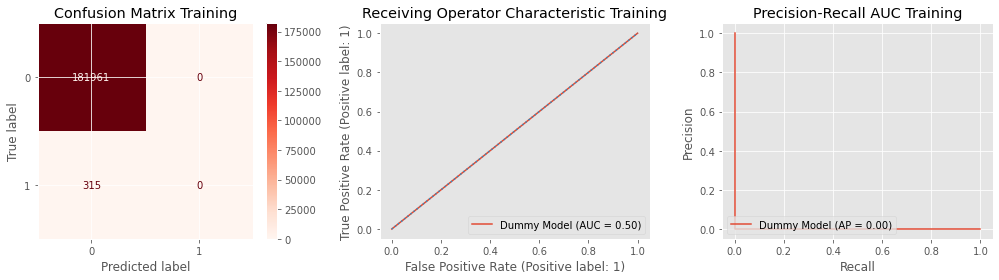

------------------------------------------------------------
Dummy Model CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.00      0.00      0.00        79

    accuracy                           1.00     45569
   macro avg       0.50      0.50      0.50     45569
weighted avg       1.00      1.00      1.00     45569



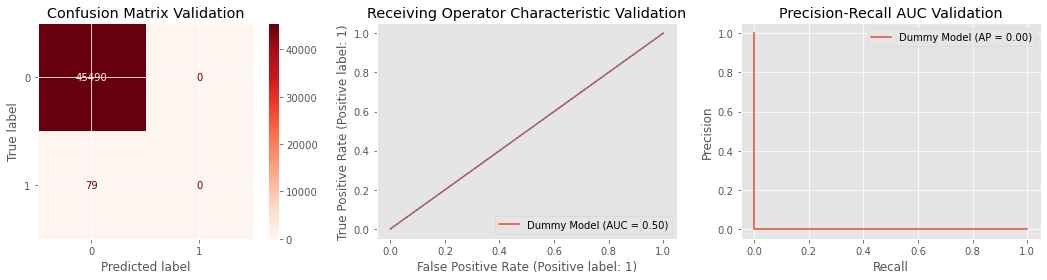

In [308]:
# classification report using function 
evaluate_classification(dummy_model_pipe,
                        X_train, 
                        X_val, 
                        y_train, 
                        y_val, 
                        label='Dummy Model')

## Logistic Regression

In [270]:
# pipeline will preprocess data and instantiate classifier
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),    # default 
    ('classifier', LogisticRegression(solver='lbfgs', random_state=42))
])

In [271]:
# fit pipeline to training data
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('time',
                                                  Pipeline(steps=[('time_converter',
                                                                   FunctionTransformer(func=<function convert_to_hours at 0x7fbff6a85670>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0]),
                                                 ('amount',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(quantile_range=(25,
                                                                                                75)))]),
                                                  [29])])),
                ('classifier', LogisticRegression(random_state=42))])

In [301]:
# evaluate the pipeline on the validation data
score = logreg_pipeline.score(X_val, y_val)
print('Validation accuracy:', score)
# use cross-validation to evaluate the pipeline
cv_scores = cross_val_score(logreg_pipeline, X_train, y_train, cv=5, scoring='recall')
print("Cross-validation recall: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Validation accuracy: 0.6843029252342602
Cross-validation recall: 0.66 (+/- 0.22)


------------------------------------------------------------
Logistic Regression Model CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.16      0.28    181961
           1       0.00      0.76      0.00       315

    accuracy                           0.16    182276
   macro avg       0.50      0.46      0.14    182276
weighted avg       1.00      0.16      0.28    182276



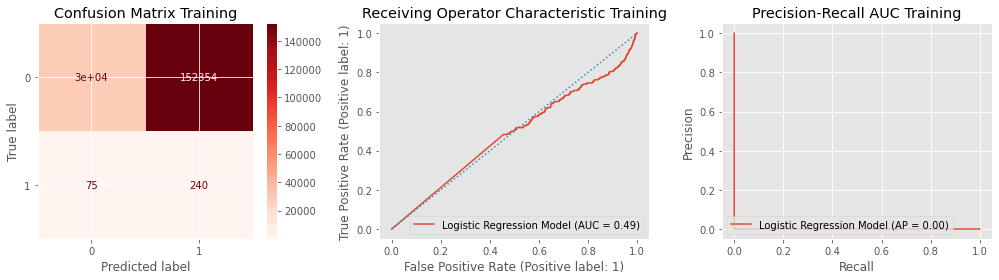

------------------------------------------------------------
Logistic Regression Model CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.16      0.28     45490
           1       0.00      0.72      0.00        79

    accuracy                           0.16     45569
   macro avg       0.50      0.44      0.14     45569
weighted avg       1.00      0.16      0.28     45569



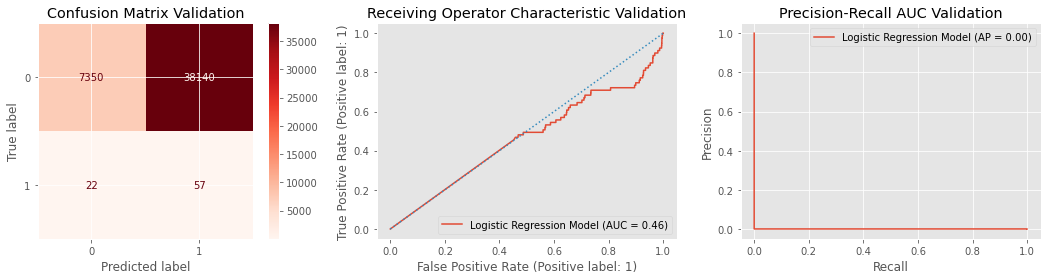

In [316]:
# classification report using function 
evaluate_classification(logreg_pipeline,
                        X_train, 
                        X_val, 
                        y_train, 
                        y_val, 
                        label='Logistic Regression Model')

Comparing Sampling Methods using imbPipeline

In [317]:
# defining the sampling methods
sampling_methods = [
    ('Random Under-sampling', RandomUnderSampler(sampling_strategy='majority', random_state=42)),
    ('Random Over-sampling', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('SMOTE', SMOTE(sampling_strategy='minority', random_state=42)),
    ('ADASYN', ADASYN(sampling_strategy='minority', random_state=42))
]

For Loop over Modified Pipeline

In [318]:
def evaluate_sampling_method(sampling_methods, X_train, X_val, y_train, y_val, classifier, random_state=42):
    """
    Evaluate different sampling methods with a given classifier on the given data.
    
    Parameters:
        - sampling_methods: a list of tuples, each containing a string name for the method 
          and the sampler instance.
        - X_train: the training set features.
        - X_val: the validation set features.
        - y_train: the training set target.
        - y_val: the validation set target.
        - classifier: the classifier pipeline to use.
        - random_state: the random state for the classifier.
    """
    for name, method in sampling_methods:
        pipeline_resampled = imbPipeline([
            ('preprocessor', preprocessor),
            ('sampler', method),
            ('classifier', classifier)
        ])

        # Use cross-validation to evaluate the pipeline
        cv_scores = cross_val_score(pipeline_resampled, X_train, y_train, cv=5, scoring='recall_macro')

        print(f"{name} CV Recall: {cv_scores.mean()} (+/- {cv_scores.std()})")

        # Fit the pipeline on the training data
        pipeline_resampled.fit(X_train, y_train)

        # Predict the classes on the validation data
        y_pred_val = pipeline_resampled.predict(X_val)

        # Compute the recall score
        recall = recall_score(y_val, y_pred_val, average='macro')

        # Print the results
        print(f'{name} Validation Recall: {recall:.3f}')

        # Evaluate the pipeline on the validation data
        evaluate_classification(pipeline_resampled,
                                X_train, 
                                X_val, 
                                y_train, 
                                y_val, 
                                label=f'{name}')

Random Under-sampling CV Recall: 0.9344585796462834 (+/- 0.0248206946059813)
Random Under-sampling Validation Recall: 0.572
------------------------------------------------------------
Random Under-sampling CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.17      0.29    181961
           1       0.00      0.98      0.00       315

    accuracy                           0.17    182276
   macro avg       0.50      0.58      0.15    182276
weighted avg       1.00      0.17      0.29    182276



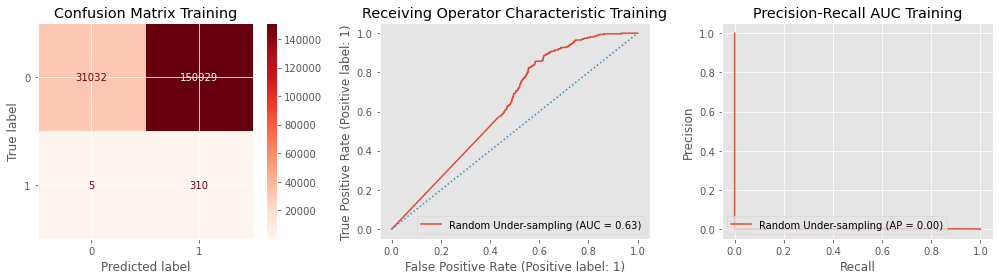

------------------------------------------------------------
Random Under-sampling CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.17      0.29     45490
           1       0.00      0.97      0.00        79

    accuracy                           0.17     45569
   macro avg       0.50      0.57      0.15     45569
weighted avg       1.00      0.17      0.29     45569



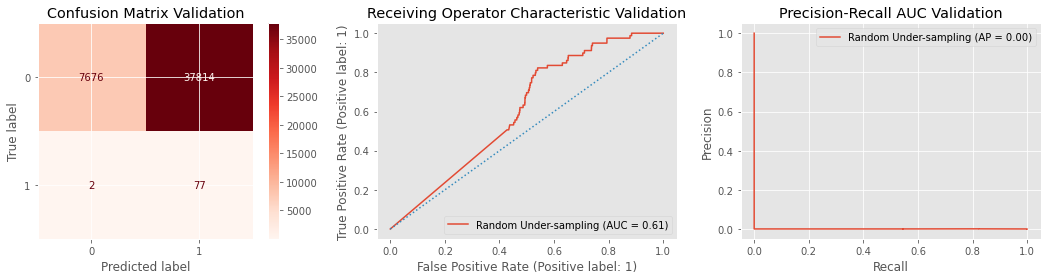

Random Over-sampling CV Recall: 0.9418502785305183 (+/- 0.01758156076521571)
Random Over-sampling Validation Recall: 0.536
------------------------------------------------------------
Random Over-sampling CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.10      0.18    181961
           1       0.00      0.99      0.00       315

    accuracy                           0.10    182276
   macro avg       0.50      0.55      0.09    182276
weighted avg       1.00      0.10      0.18    182276



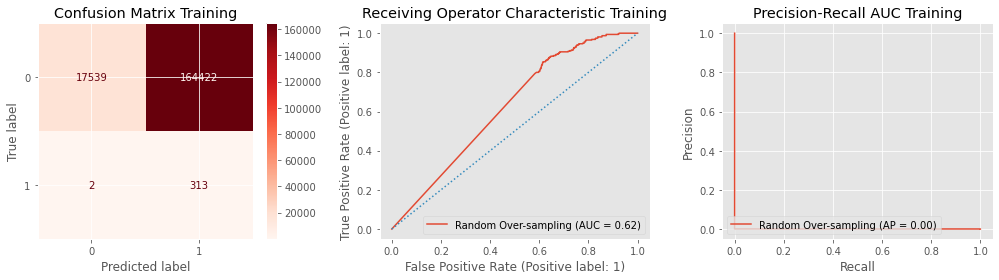

------------------------------------------------------------
Random Over-sampling CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.10      0.18     45490
           1       0.00      0.97      0.00        79

    accuracy                           0.10     45569
   macro avg       0.50      0.54      0.09     45569
weighted avg       1.00      0.10      0.18     45569



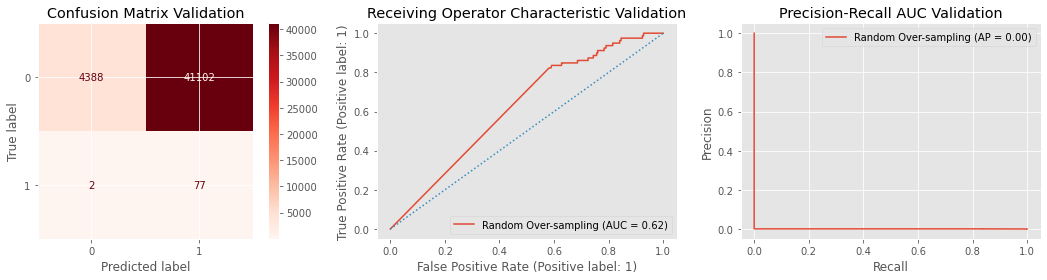

SMOTE CV Recall: 0.9414051273352941 (+/- 0.01308358601065361)
SMOTE Validation Recall: 0.535
------------------------------------------------------------
SMOTE CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.09      0.17    181961
           1       0.00      0.99      0.00       315

    accuracy                           0.10    182276
   macro avg       0.50      0.54      0.09    182276
weighted avg       1.00      0.10      0.17    182276



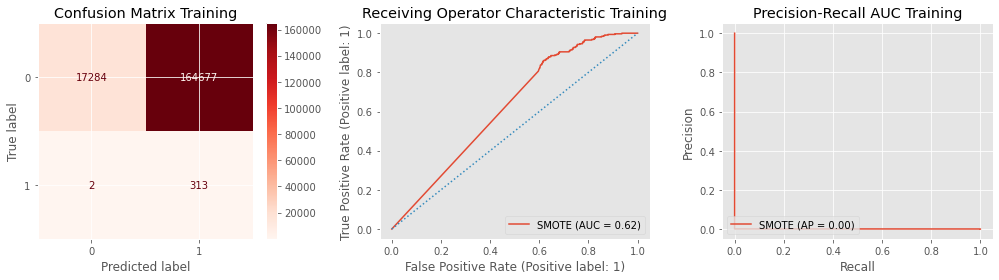

------------------------------------------------------------
SMOTE CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.09      0.17     45490
           1       0.00      0.97      0.00        79

    accuracy                           0.10     45569
   macro avg       0.50      0.53      0.09     45569
weighted avg       1.00      0.10      0.17     45569



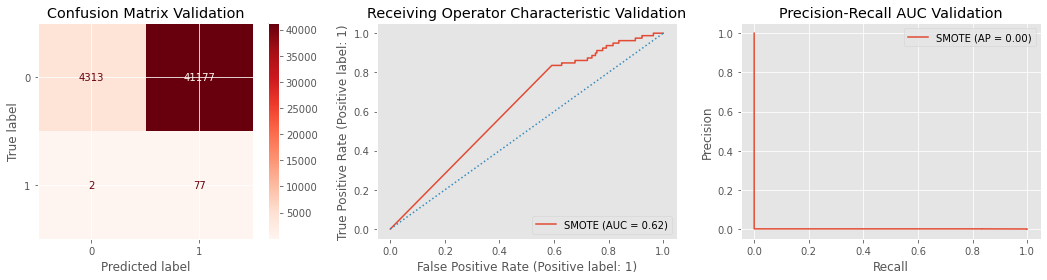

ADASYN CV Recall: 0.9342631819918811 (+/- 0.01735366437682172)
ADASYN Validation Recall: 0.504
------------------------------------------------------------
ADASYN CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.02      0.04    181961
           1       0.00      1.00      0.00       315

    accuracy                           0.02    182276
   macro avg       0.50      0.51      0.02    182276
weighted avg       1.00      0.02      0.04    182276



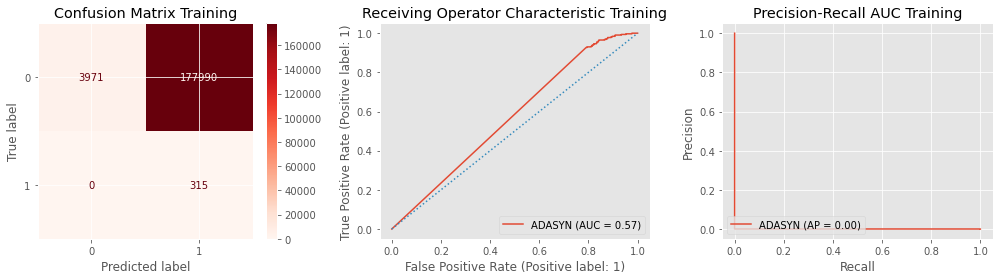

------------------------------------------------------------
ADASYN CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.02      0.04     45490
           1       0.00      0.99      0.00        79

    accuracy                           0.02     45569
   macro avg       0.50      0.50      0.02     45569
weighted avg       1.00      0.02      0.04     45569



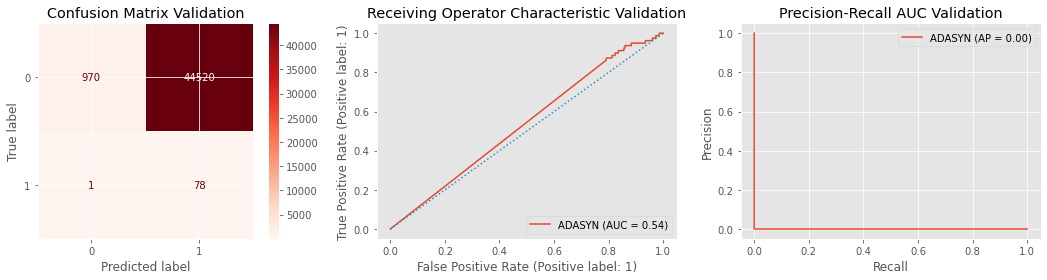

In [319]:
# evaluate sampling methods with logistic regression using function
evaluate_sampling_method(sampling_methods, 
                         X_train, 
                         X_val, 
                         y_train, 
                         y_val, 
                         classifier=logreg_pipeline, 
                         random_state=42)

## Decision Trees

In [320]:
# pipeline will preprocess data and instantiate classifier
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [321]:
# fit pipeline to training data
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('time',
                                                  Pipeline(steps=[('time_converter',
                                                                   FunctionTransformer(func=<function convert_to_hours at 0x7fbff6a85670>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0]),
                                                 ('amount',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(quantile_range=(25,
                                                                                                75)))]),
                                                  [29])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [322]:
# evaluate the pipeline on the validation data
score = dt_pipeline.score(X_val, y_val)
print('Validation accuracy:', score)
# use cross-validation to evaluate the pipeline
cv_scores = cross_val_score(dt_pipeline, X_train, y_train, cv=5, scoring='recall')
print("Cross-validation recall: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Validation accuracy: 0.998990541815708
Cross-validation recall: 0.76 (+/- 0.10)


------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181961
           1       1.00      1.00      1.00       315

    accuracy                           1.00    182276
   macro avg       1.00      1.00      1.00    182276
weighted avg       1.00      1.00      1.00    182276



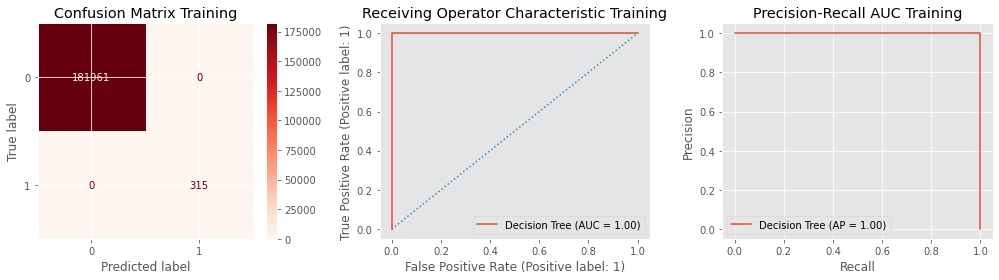

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.70      0.72      0.71        79

    accuracy                           1.00     45569
   macro avg       0.85      0.86      0.86     45569
weighted avg       1.00      1.00      1.00     45569



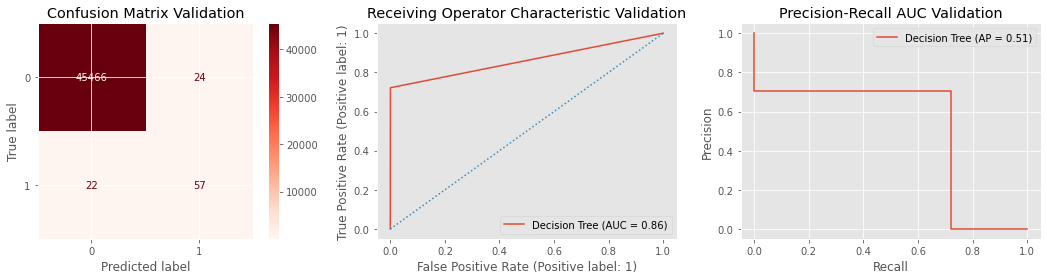

In [323]:
# classification report using function 
evaluate_classification(dt_pipeline,
                        X_train, 
                        X_val, 
                        y_train, 
                        y_val, 
                        label='Decision Tree')

Random Under-sampling CV Recall: 0.9134264974407167 (+/- 0.0186864048048491)
Random Under-sampling Validation Recall: 0.877
------------------------------------------------------------
Random Under-sampling CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    181961
           1       0.01      0.99      0.03       315

    accuracy                           0.88    182276
   macro avg       0.51      0.94      0.48    182276
weighted avg       1.00      0.88      0.94    182276



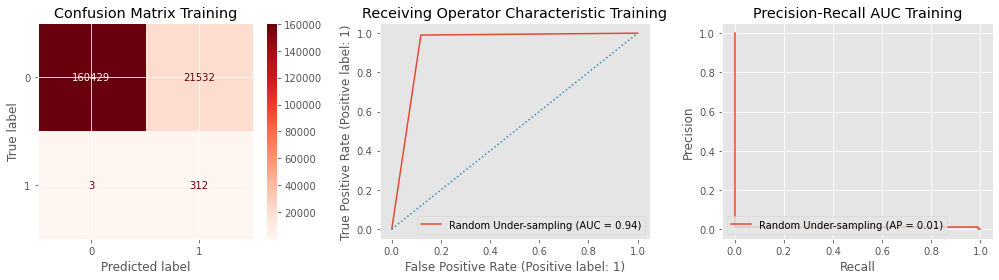

------------------------------------------------------------
Random Under-sampling CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     45490
           1       0.01      0.87      0.02        79

    accuracy                           0.88     45569
   macro avg       0.51      0.88      0.48     45569
weighted avg       1.00      0.88      0.93     45569



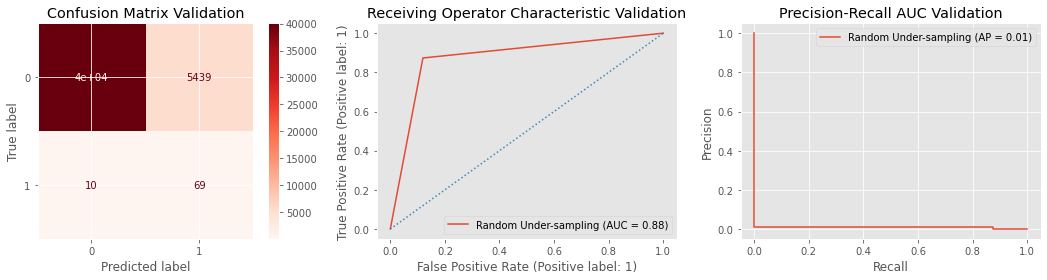

Random Over-sampling CV Recall: 0.8632914708610834 (+/- 0.015381565825800702)
Random Over-sampling Validation Recall: 0.829
------------------------------------------------------------
Random Over-sampling CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181961
           1       1.00      0.90      0.95       315

    accuracy                           1.00    182276
   macro avg       1.00      0.95      0.97    182276
weighted avg       1.00      1.00      1.00    182276



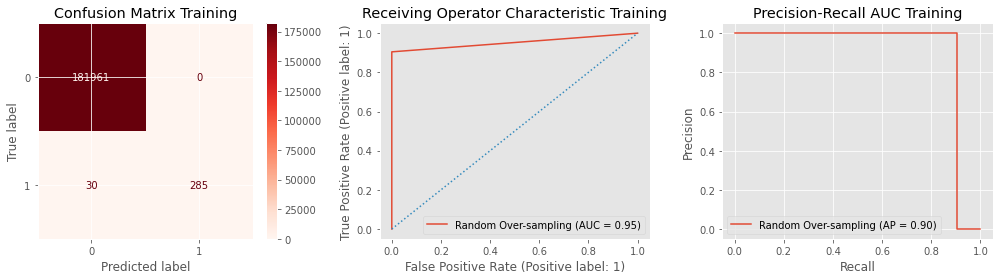

------------------------------------------------------------
Random Over-sampling CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.79      0.66      0.72        79

    accuracy                           1.00     45569
   macro avg       0.89      0.83      0.86     45569
weighted avg       1.00      1.00      1.00     45569



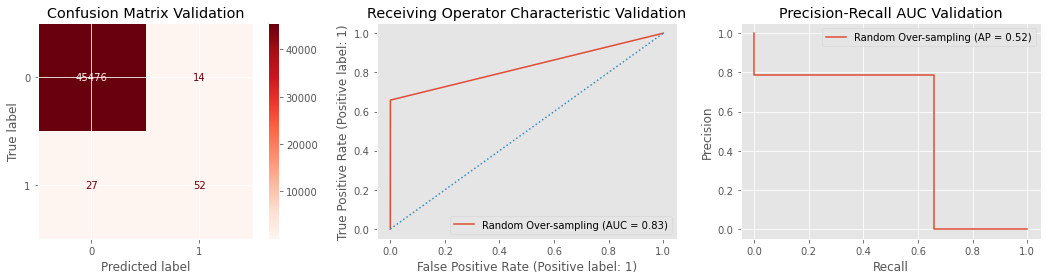

SMOTE CV Recall: 0.883014108441829 (+/- 0.014684712300414486)
SMOTE Validation Recall: 0.706
------------------------------------------------------------
SMOTE CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.70      0.83    181961
           1       0.01      0.99      0.01       315

    accuracy                           0.70    182276
   macro avg       0.50      0.85      0.42    182276
weighted avg       1.00      0.70      0.82    182276



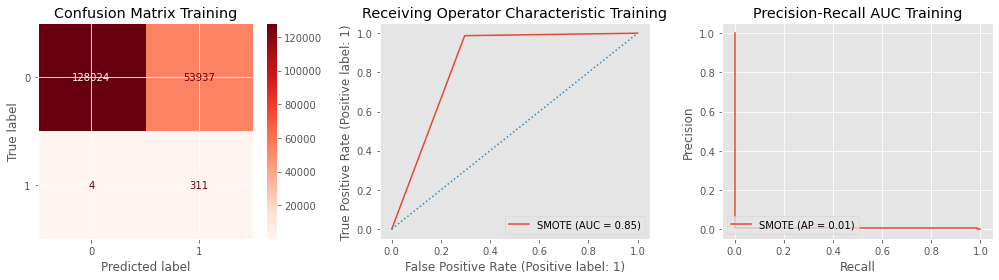

------------------------------------------------------------
SMOTE CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     45490
           1       0.00      0.71      0.01        79

    accuracy                           0.70     45569
   macro avg       0.50      0.71      0.42     45569
weighted avg       1.00      0.70      0.82     45569



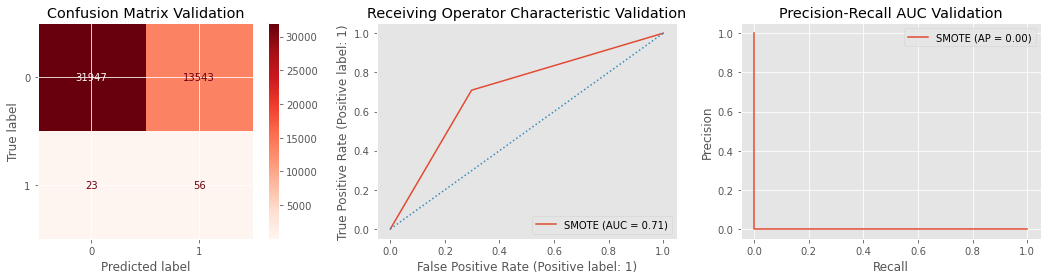

ADASYN CV Recall: 0.8609897303898745 (+/- 0.018474241721616068)
ADASYN Validation Recall: 0.832
------------------------------------------------------------
ADASYN CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    181961
           1       0.25      0.99      0.39       315

    accuracy                           0.99    182276
   macro avg       0.62      0.99      0.70    182276
weighted avg       1.00      0.99      1.00    182276



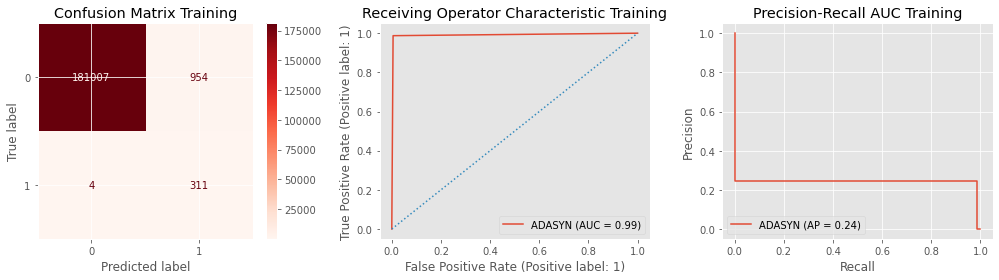

------------------------------------------------------------
ADASYN CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     45490
           1       0.14      0.67      0.23        79

    accuracy                           0.99     45569
   macro avg       0.57      0.83      0.61     45569
weighted avg       1.00      0.99      0.99     45569



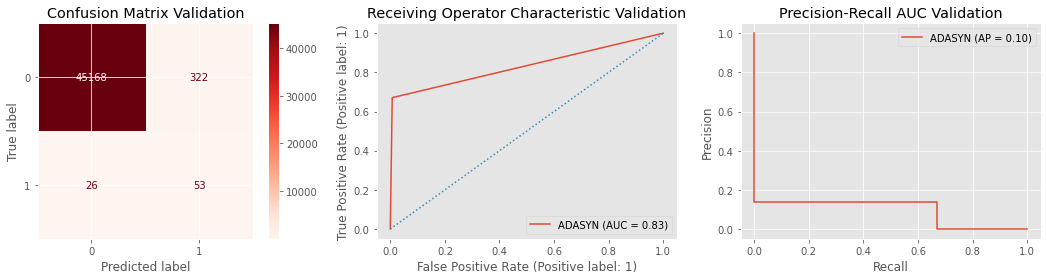

In [324]:
# evaluate sampling methods with decision tree using function
evaluate_sampling_method(sampling_methods, 
                         X_train, 
                         X_val, 
                         y_train, 
                         y_val, 
                         classifier=dt_pipeline, 
                         random_state=42)

## Random Forest

In [325]:
# pipeline will preprocess data and instantiate classifier
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [326]:
# fit pipeline to training data
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('time',
                                                  Pipeline(steps=[('time_converter',
                                                                   FunctionTransformer(func=<function convert_to_hours at 0x7fbff6a85670>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0]),
                                                 ('amount',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(quantile_range=(25,
                                                                                                75)))]),
                                                  [29])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [327]:
# evaluate the pipeline on the validation data
score = rf_pipeline.score(X_val, y_val)
print('Validation accuracy:', score)
# use cross-validation to evaluate the pipeline
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='recall')
print("Cross-validation recall: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Validation accuracy: 0.9994294366784436
Cross-validation recall: 0.76 (+/- 0.06)


------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181961
           1       1.00      1.00      1.00       315

    accuracy                           1.00    182276
   macro avg       1.00      1.00      1.00    182276
weighted avg       1.00      1.00      1.00    182276



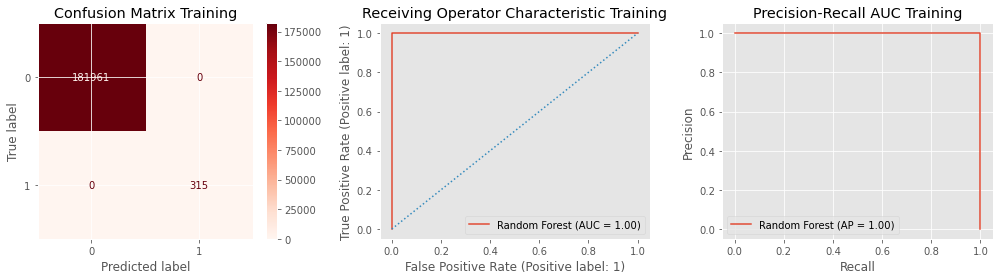

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.93      0.72      0.81        79

    accuracy                           1.00     45569
   macro avg       0.97      0.86      0.91     45569
weighted avg       1.00      1.00      1.00     45569



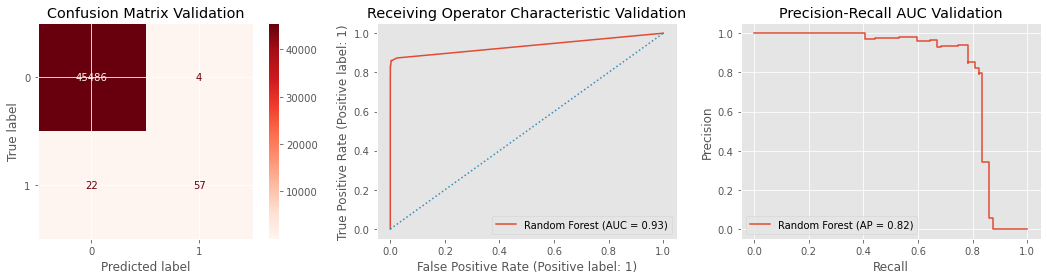

In [328]:
# classification report using function 
evaluate_classification(rf_pipeline,
                        X_train, 
                        X_val, 
                        y_train, 
                        y_val, 
                        label='Random Forest')

Random Under-sampling CV Recall: 0.9388625277219701 (+/- 0.010353812568128081)
Random Under-sampling Validation Recall: 0.921
------------------------------------------------------------
Random Under-sampling CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    181961
           1       0.05      1.00      0.10       315

    accuracy                           0.97    182276
   macro avg       0.53      0.98      0.54    182276
weighted avg       1.00      0.97      0.98    182276



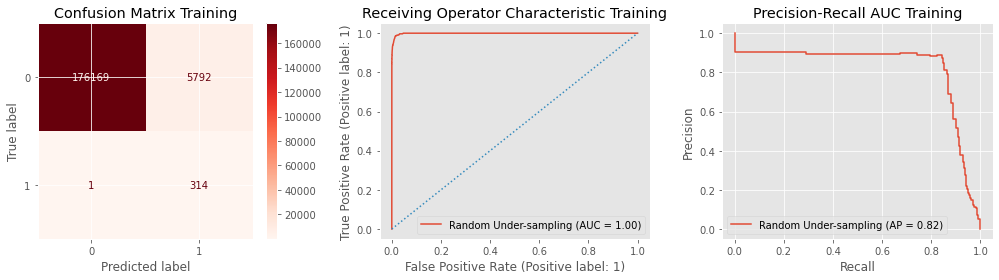

------------------------------------------------------------
Random Under-sampling CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     45490
           1       0.04      0.87      0.09        79

    accuracy                           0.97     45569
   macro avg       0.52      0.92      0.53     45569
weighted avg       1.00      0.97      0.98     45569



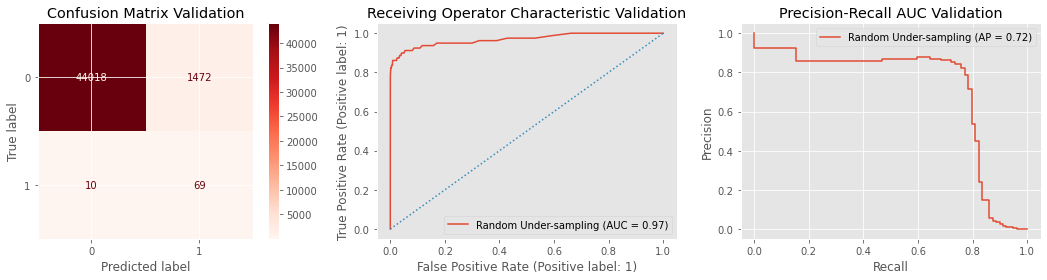

Random Over-sampling CV Recall: 0.8904294772902954 (+/- 0.016181183444872533)
Random Over-sampling Validation Recall: 0.854
------------------------------------------------------------
Random Over-sampling CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181961
           1       1.00      1.00      1.00       315

    accuracy                           1.00    182276
   macro avg       1.00      1.00      1.00    182276
weighted avg       1.00      1.00      1.00    182276



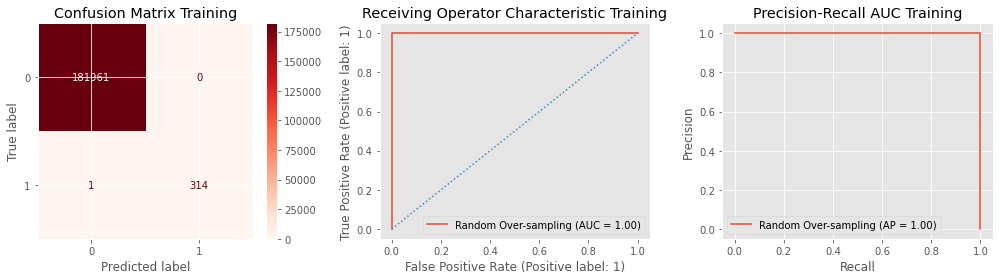

------------------------------------------------------------
Random Over-sampling CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.89      0.71      0.79        79

    accuracy                           1.00     45569
   macro avg       0.94      0.85      0.89     45569
weighted avg       1.00      1.00      1.00     45569



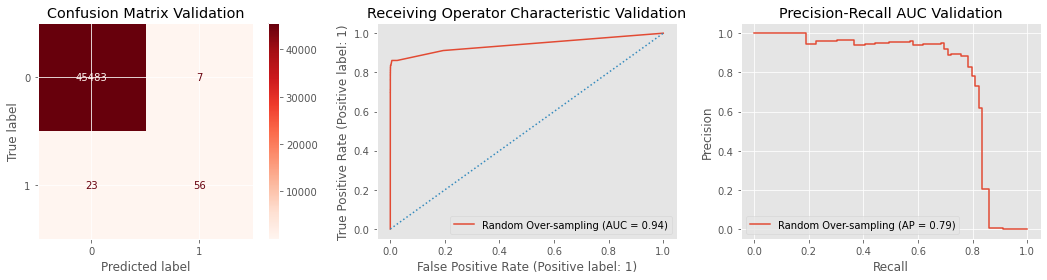

SMOTE CV Recall: 0.9030756811649745 (+/- 0.018350388630434714)
SMOTE Validation Recall: 0.892
------------------------------------------------------------
SMOTE CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181961
           1       0.99      1.00      1.00       315

    accuracy                           1.00    182276
   macro avg       1.00      1.00      1.00    182276
weighted avg       1.00      1.00      1.00    182276



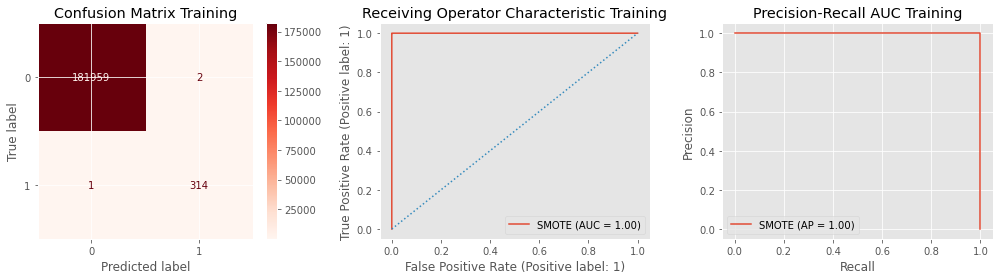

------------------------------------------------------------
SMOTE CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.85      0.78      0.82        79

    accuracy                           1.00     45569
   macro avg       0.92      0.89      0.91     45569
weighted avg       1.00      1.00      1.00     45569



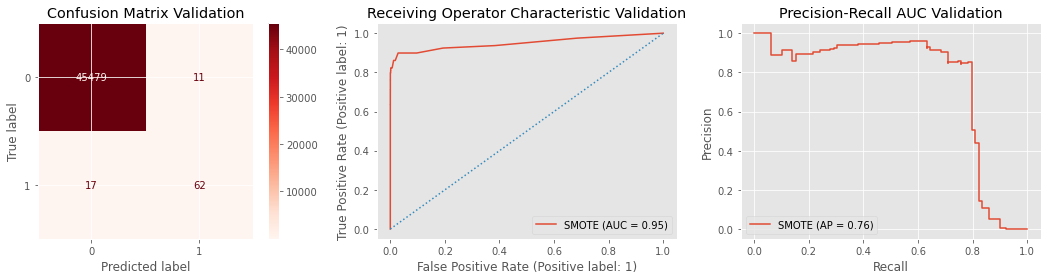

ADASYN CV Recall: 0.9046657305334428 (+/- 0.020680087700469914)
ADASYN Validation Recall: 0.886
------------------------------------------------------------
ADASYN CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181961
           1       0.99      0.99      0.99       315

    accuracy                           1.00    182276
   macro avg       1.00      1.00      1.00    182276
weighted avg       1.00      1.00      1.00    182276



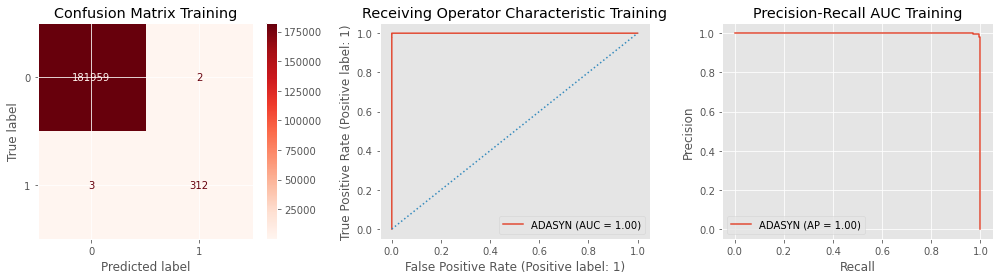

------------------------------------------------------------
ADASYN CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.81      0.77      0.79        79

    accuracy                           1.00     45569
   macro avg       0.91      0.89      0.90     45569
weighted avg       1.00      1.00      1.00     45569



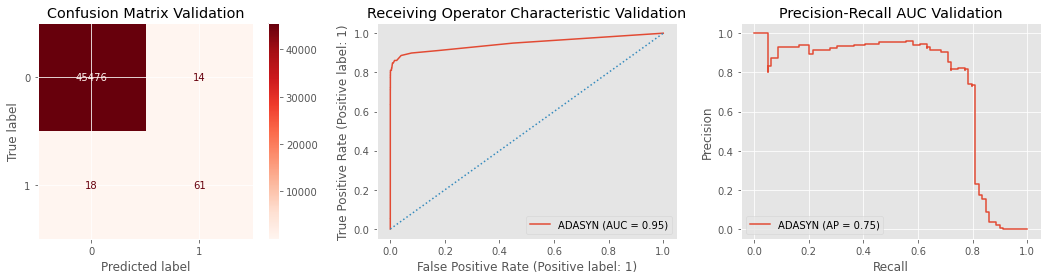

In [329]:
# evaluate sampling methods with random forest using function
evaluate_sampling_method(sampling_methods, 
                         X_train, 
                         X_val, 
                         y_train, 
                         y_val, 
                         classifier=rf_pipeline, 
                         random_state=42)

## Support Vector Machines (SVM) - Linear

In [334]:
# pipeline will preprocess data and instantiate classifier
svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', random_state=42, probability=True))
])

In [335]:
# fit pipeline to training data
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('time',
                                                  Pipeline(steps=[('time_converter',
                                                                   FunctionTransformer(func=<function convert_to_hours at 0x7fbff6a85670>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0]),
                                                 ('amount',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(quantile_range=(25,
                                                                                                75)))]),
                                                  [29])])),
                ('classifier',
                 SVC(kernel='linear', probability=True, random_state=42))])

In [336]:
# evaluate the pipeline on the validation data
score = svc_pipeline.score(X_val, y_val)
print('Validation accuracy:', score)
# use cross-validation to evaluate the pipeline
cv_scores = cross_val_score(svc_pipeline, X_train, y_train, cv=5, scoring='recall')
print("Cross-validation recall: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Validation accuracy: 0.9992099892470758
Cross-validation recall: 0.78 (+/- 0.07)


------------------------------------------------------------
SVM (Linear) CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181961
           1       0.88      0.78      0.83       315

    accuracy                           1.00    182276
   macro avg       0.94      0.89      0.91    182276
weighted avg       1.00      1.00      1.00    182276



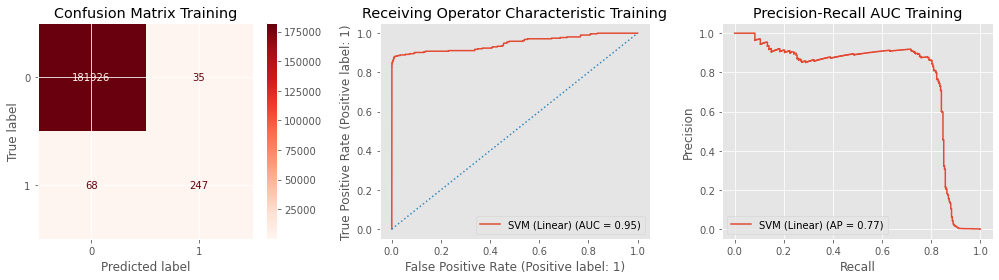

------------------------------------------------------------
SVM (Linear) CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.82      0.70      0.75        79

    accuracy                           1.00     45569
   macro avg       0.91      0.85      0.88     45569
weighted avg       1.00      1.00      1.00     45569



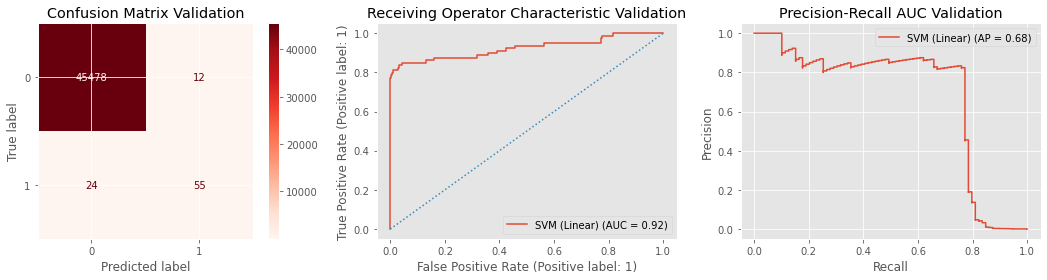

In [337]:
# classification report using function 
evaluate_classification(svc_pipeline,
                        X_train, 
                        X_val, 
                        y_train, 
                        y_val, 
                        label='SVM (Linear)')

Random Under-sampling CV Recall: 0.9396362627398753 (+/- 0.017493429021970777)
Random Under-sampling Validation Recall: 0.547
------------------------------------------------------------
Random Under-sampling CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.12      0.21    181961
           1       0.00      0.99      0.00       315

    accuracy                           0.12    182276
   macro avg       0.50      0.55      0.11    182276
weighted avg       1.00      0.12      0.21    182276



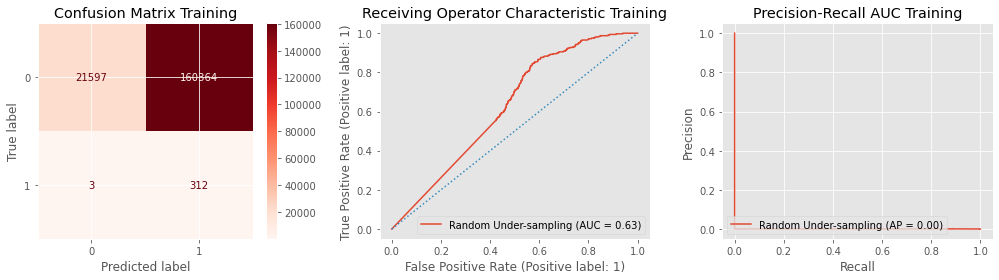

------------------------------------------------------------
Random Under-sampling CLASSIFICATION REPORT VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.12      0.21     45490
           1       0.00      0.97      0.00        79

    accuracy                           0.12     45569
   macro avg       0.50      0.55      0.11     45569
weighted avg       1.00      0.12      0.21     45569



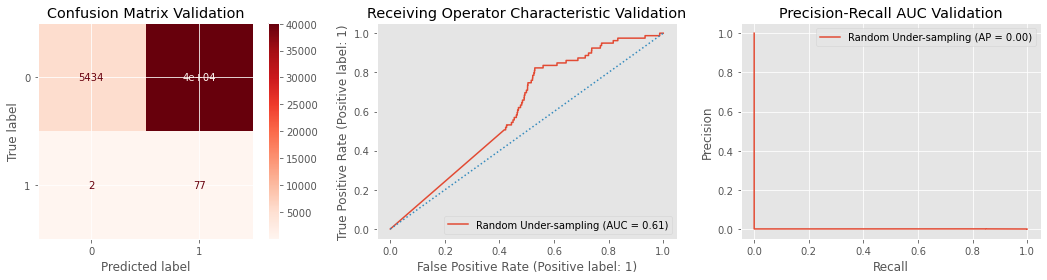

In [ ]:
# evaluate sampling methods with support vector machine using function
evaluate_sampling_method(sampling_methods, 
                         X_train, 
                         X_val, 
                         y_train, 
                         y_val, 
                         classifier=svc_pipeline, 
                         random_state=42)

## Support Vector Machines (SVM) -  RBF

In [ ]:
# pipeline will preprocess data and instantiate classifier
svc_rbf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', random_state=42, probability=True))
])

In [ ]:
# fit pipeline to training data
svc_rbf_pipeline.fit(X_train, y_train)

In [ ]:
# evaluate the pipeline on the validation data
score = svc_rbf_pipeline.score(X_val, y_val)
print('Validation accuracy:', score)
# use cross-validation to evaluate the pipeline
cv_scores = cross_val_score(svc_rbf_pipeline, X_train, y_train, cv=5, scoring='recall')
print("Cross-validation recall: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

In [ ]:
# classification report using function 
evaluate_classification(svc_rbf_pipeline,
                        X_train, 
                        X_val, 
                        y_train, 
                        y_val, 
                        label='SVM (RBF)')

In [ ]:
# evaluate sampling methods with support vector machine using function
evaluate_sampling_method(sampling_methods, 
                         X_train, 
                         X_val, 
                         y_train, 
                         y_val, 
                         classifier=svc_rbf_pipeline, 
                         random_state=42)

## Naive Bayes

In [ ]:
# pipeline will preprocess data and instantiate classifier
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [ ]:
# fit pipeline to training data
nb_pipeline.fit(X_train, y_train)

In [ ]:
# evaluate the pipeline on the validation data
score = nb_pipeline.score(X_val, y_val)
print('Validation accuracy:', score)
# use cross-validation to evaluate the pipeline
cv_scores = cross_val_score(nb_pipeline, X_train, y_train, cv=5, scoring='recall')
print("Cross-validation recall: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

In [ ]:
# classification report using function 
evaluate_classification(nb_pipeline,
                        X_train, 
                        X_val, 
                        y_train, 
                        y_val, 
                        label='Naive Bayes')

In [ ]:
# evaluate sampling methods with naive bayes using function
evaluate_sampling_method(sampling_methods, 
                         X_train, 
                         X_val, 
                         y_train, 
                         y_val, 
                         classifier=nb_pipeline, 
                         random_state=42)

## K-Nearest Neighbors (KNN)

In [ ]:
# pipeline will preprocess data and instantiate classifier
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

In [ ]:
# fit pipeline to training data
knn_pipeline.fit(X_train, y_train)

In [ ]:
# evaluate the pipeline on the validation data
score = knn_pipeline.score(X_val, y_val)
print('Validation accuracy:', score)
# use cross-validation to evaluate the pipeline
cv_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring='recall')
print("Cross-validation recall: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

In [ ]:
# classification report using function 
evaluate_classification(knn_pipeline,
                        X_train, 
                        X_val, 
                        y_train, 
                        y_val, 
                        label='K-Nearest Neighbors')

In [ ]:
# evaluate sampling methods with naive bayes using function
evaluate_sampling_method(sampling_methods, 
                         X_train, 
                         X_val, 
                         y_train, 
                         y_val, 
                         classifier=knn_pipeline, 
                         random_state=42)

## Gradient Boosting Machines (GBM)

In [ ]:
# pipeline will preprocess data and instantiate classifier
gbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [ ]:
# fit pipeline to training data
gbm_pipeline.fit(X_train, y_train)

In [ ]:
# evaluate the pipeline on the validation data
score = gbm_pipeline.score(X_val, y_val)
print('Validation accuracy:', score)
# use cross-validation to evaluate the pipeline
cv_scores = cross_val_score(gbm_pipeline, X_train, y_train, cv=5, scoring='recall')
print("Cross-validation recall: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

In [ ]:
# classification report using function 
evaluate_classification(gbm_pipeline,
                        X_train, 
                        X_val, 
                        y_train, 
                        y_val, 
                        label='Gradient Boosting')

In [ ]:
### Testing Sampling Methods

In [ ]:
# evaluate sampling methods with gradient boost using function
evaluate_sampling_method(sampling_methods, 
                         X_train, 
                         X_val, 
                         y_train, 
                         y_val, 
                         classifier=gbm_pipeline, 
                         random_state=42)

In [ ]:
<b>Notes:</b> 
    
<b>Next:</b>

## Multi-layer Perceptron (MLP) Network

In [ ]:
# pipeline will preprocess data and instantiate classifier
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=1000, random_state=42))
])

In [ ]:
# fit pipeline to training data
mlp_pipeline.fit(X_train, y_train)

In [ ]:
# evaluate the pipeline on the validation data
score = mlp_pipeline.score(X_val, y_val)
print('Validation accuracy:', score)
# use cross-validation to evaluate the pipeline
cv_scores = cross_val_score(mlp_pipeline, X_train, y_train, cv=5, scoring='recall')
print("Cross-validation recall: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

In [ ]:
# classification report using function 
evaluate_classification(mlp_pipeline,
                        X_train, 
                        X_val, 
                        y_train, 
                        y_val, 
                        label='Gradient Boosting')

In [ ]:
# evaluate sampling methods with mlp using function
evaluate_sampling_method(sampling_methods, 
                         X_train, 
                         X_val, 
                         y_train, 
                         y_val, 
                         classifier=mlp_pipeline, 
                         random_state=42)

<b>Notes:</b> 
    
<b>Next:</b> We will perform a grid search on the best performing model to see if finding the model's optimal parameters can increase its performance.

## Grid Search

In [ ]:
# param dictionary

In [ ]:
# pipeline w gridsearch

In [ ]:
# fit grid search
gs.fit

In [164]:
# Use the final test set to evaluate the pipeline
y_pred = pipeline.predict(X_test)
recall_test = recall_score(y_test, y_pred)
print("Test recall: ", recall_test)

Test recall:  0.5816326530612245


## Final Model

## Feature Importance

## Results

## Next Steps:
    
    - More data
    - Remove duplicates
    